# ECS659U/P/7026P Coursework : CIFAR-10 classification
<div style="text-align: right"> Student name : Khangerel Nasantogtokh </div>
<div style="text-align: right"> Student number : 220984838 </div>

**Table of Contents**

1. Section 1: Introduction
      
2. Section 2: Read the dataset and create data loaders
      * 2.1: Downloading data set
      * 2.2: Data Transformation and Augmentation
      * 2.3: Displaying dataset
      
3. Section 3: Model Implementation
      * 3.1: Model Architecture
      * 3.2: Backbone
      * 3.3: Classifier
      
4. Section 4: Loss and Optimizer
      * 4.1: Loss function and Initialization Method
      * 4.2: Optimizer and Hyperparameters
      
5. Section 5: Training 
      * 5.1: Training script
      * 5.2: Test script
      * 5.3: Calculation of average training and test accuracy/loss over epoch

6. Section 6: Model Performance
      * 5.1: Training and Test accuracy Curve
      * 5.2: Loss Curve
      * 5.3: Testing

In [135]:
#Setup Environment
""" mps(apple metal) or gpu or cpu is set to use here.
reference: https://github.com/jeffheaton/t81_558_deep_learning/blob/pytorch/install/pytorch-install-aug-2022.ipynb"""

import sys
import platform # provides an interface for accessing platform-specific details
import torch 

has_gpu = torch.cuda.is_available() # check gpu is available
has_mps = getattr(torch,'has_mps',False) # chek mps (apple metal) is available

#set device to mps or gpu or cpu
device = "mps" if getattr(torch,'has_mps',False) \
    else torch.device("cuda") if torch.cuda.is_available() else "cpu"

#Displaying versions
print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Python {sys.version}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.1-arm64-arm-64bit
PyTorch Version: 2.1.0.dev20230320
Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [136]:
# importing essential libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = set(['retina']) # set figure to high resolution
sns.set_style('darkgrid') #sets the style for Seaborn plots to "darkgrid"

## Section 1. Introduction
This notebook presents the implementation deep learning model (Convolutional neural network) for "CIFAR10" image classification. The aim is to get the highest test accuracy using the specific given model which is detailed in Section 3. 

The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. The ten classes include trucks, frogs, horses, deer, dogs, cats, birds, cats, ships, and cars. Each class has 6,000 photos in total.

Section 2 loads the data and prepares data loaders such as training data and test data. Section 3 describes the model architecture, and implements the backbone and classifier. In Section 4, the Loss function, Optimizer and Hyperparameters are defined and explained. Section 5 outlines the training and test scripts. Section 6 shows the visualization of model performance such as learning curve and heatmap for each class

## Section 2. Load and Prepare the data

#### 2.1 Downloading dataset

'Torchvision.datasets' module provides a set of standard datasets, including CIFAR10, and downloading the dataset can be done using the PyTorch library.

In [23]:
#Defining transform for converting image to  Tensor
transform = transforms.Compose([transforms.ToTensor()])

#Downloading data
dataset_train = torchvision.datasets.CIFAR10(
    root='./data',  # The root directory where the dataset will be stored
    train=True,  # Specifies training set
    download=True,  # Specifies whether to download the dataset from the internet
    transform=transform)# using defined transformation

Files already downloaded and verified


#### 2.2 Data transformation and Augmentation
In following code sections, preprocessing step is applied for dataset. The initial step involves applying the mean and standard deviation to normalize the 3 color RGB channels of the training set's images in order to achieve a zero mean and unit variance. Since the pixel range of a color image is 0–255, we can get the mean and standard deviation of the RGB channels across all images in the training set. This helps in preventing any bias during model training toward a specific pixel range or mean. 

* The transformation pipeline for the training dataset includes random cropping size of 32 with padding of size 4 on each side, random horizontal flipping with chance of 0.5, and normalisation. Also, a type of padding mode that reflects the pixels of an image at the edges, is added. This can expand the training set and decrease overfitting of the model by random cropping and flipping.
* For the test dataset, only normalization is performed to maintain consistency across both datasets. 
* Data loaders are created for training and test datasets with a batch size of 128 to ensure faster training since larger batch size can lead to faster training.  

reference at: "Ratner, A.J., Ehrenberg, H., Hussain, Z., Dunnmon, J. and Ré, C., 2017. Learning to compose domain-specific transformations for data augmentation. Advances in neural information processing systems, 30"

In [24]:
#Calculating mean values of 3 color channels (RGB)
mean_data = dataset_train.data.mean(axis = (0,1,2))/255

#Calculating standard deviation of 3 color channels (RGB)
std_data = dataset_train.data.std(axis = (0,1,2))/255

print('Mean:', mean_data) #printing mean values
print('Standard deviation:', std_data) #printing standard deviations

Mean: [0.49139968 0.48215841 0.44653091]
Standard deviation: [0.24703223 0.24348513 0.26158784]


In [25]:
#Define transformation for training dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'), # Randomly crop the image to size 32 and pad with reflection padding of size 4 on each side
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally with a probability of 0.5
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.24703223, 0.24348513, 0.26158784)), # Normalizing dataset
])

#Define transform for test dataset
transform_test = transforms.Compose([
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.24703223, 0.24348513, 0.26158784)),# Normalizing dataset
])

#Download train dataset 
trainset = torchvision.datasets.CIFAR10(
    root='./data', # where to store
    train=True, # Specifies training set
    download=True, # whether to download from internet
    transform=transform_train)# apply defined transform for training dataset

#Creating data loader
trainloader = torch.utils.data.DataLoader(
    trainset,       # training dataset to load
    batch_size=128, # Number of images in each batch
    shuffle=True,   # after epochs, shuffle dataset
    num_workers=2)  # Number of subprocesses to use for data loading

"""Same documentation applied for downloading and creating test dataset """

#Download test dataset and apply transform for test dataset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

#Creating data loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)

# classes contains a tuple of the 10 classes for dataset
# The order of classes corresponds to the order of the labels
classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### 2.3 Displaying images

We will check images whether its properly downloaded by visualizing a random image.

reference at: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [26]:
# Loads first batch from trainloader
images, labels = next(iter(trainloader))

# Display shape of image
print(images.shape)

torch.Size([128, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


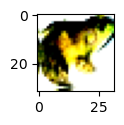

In [27]:
#Define function to display image
def show_img(image):
    """Display image using matplotlib"""
    
    converted = image.numpy() # converting tensor to numpy
    converted = np.transpose(converted, (1,2,0)) # transposing numpy to match matplotlib's format
    plt.figure(figsize = (1,1)) # Figure size
    plt.imshow(converted)
    plt.show()

# Display 6th image in the batch
print(classes[labels[5].item()])
show_img(images[5])

## Section 3. Model Implementation

#### 3.1 Basic Architecture

The model consists of backbone and classifier. 
* The backbone can consist of $N$ blocks which have a set of $K$ convolutional layers each produces feature maps and a Linear/MLP layer predicting $a$ vector $ a =[a_{1}...a_{K}]$ with K elements from input $X$ tensor. $a$ is derived as $a = g(SpatialAveragePool(X)W)$. The feature maps are then combined into a single output map by taking a weighted sum of the feature maps, where the weights are determined by vector $a$. Thus, output for one block will be \begin{align}O_{1}& =a_{1}*Conv_{1}(X) + ... a_{K}* Conv_{K}(X)\end{align}


* The Classifier takes as input the output of the last block, which is denoted as $O$. It then computes a mean feature vector $f$ using Spatial Average Pooling. The feature vector $f$ is then passed through a classifier. The classifier can be a softmax regression classifier or a multi-layer perceptron (MLP). The final output of the classifier is the predicted class label for the input image. $$ f = SpatialAveragePool(O) $$



#### 3.2 Backbone

Backbone is implemented according to the following. 

* Backbone consists of 6 blocks, each having 3 convolutional layers and fully connected layer (MLP) followed by batch normalization and ReLU activation function. In each block, 3 convolutional layers have different kernel sizes 1x1, 3x3, and 5x5 and the output of each convolutional layer is multiplied with a vector value generated by an MLP. Then, the output of each convolutional layer is summed and passed through Batch normalization and ReLU activation function. 

* Maxpooling layer with kernel size of 2x2 and stride 2 is applied after 2nd, 4th and 5th block.


| Blocks      |      Number of convulutional layers |     In Channel| Out Channel |Kernel size |
|:--------------|:------------- |:---------------|:-------------------|:-------------------|
 |1             |     3       |   3           | 32  |1x1, 3x3, 5x5  |
|2         |     3        |   32           | 32  | 1x1, 3x3, 5x5  |
|3       |     3         |   32           | 64  | 1x1, 3x3, 5x5 |
|4    |    3        |   64           | 64  | 1x1, 3x3, 5x5 |
|5      |    3      |   64           | 128  | 1x1, 3x3, 5x5 |
|6   |     3          |   128           | 128  | 1x1, 3x3, 5x5 |

* In each block, Spatial average pooling layer is used for averaging the feature maps of each channel before it passed through MLP which consists of a Linear layer followed by a ReLU activation layer, the Linear layer, and finally Sigmoid activation layer.

|Blocks|	Number of fully connected layers|	Input size|	Output size (weights for convolutional layers)|
|:--------------|:------------- |:---------------|:-------------------|
|1	|2	|3|	3|
|2|	2|	32|	3|
|3|	2|32 |3|
|4|	2|	64	|3|
|5|	2|	64	|3|
|6|	2|	128|3|

#### 3.3 Classifier
Softmax classifier is implemented. This model can take an input image and output a classification result with 10 classes. Classifier consists of several layers such as Flattening, Linear, ReLU activation, Batch normalization, Dropout, Linear, and finally Softmax layer which is a probability distribution function that is applied to the output of the previous layer, normalizing it such that the sum of the output probabilities is equal to 1. This layer produces probability distribution over the 10 possible classes.


In [28]:
"""Here backbone and classifier are combined under one class. 
   It is difficult to avoid hardcoding in this case because there 
   are multiple blocks with different layers and parameters."""

class Model(torch.nn.Module):
    def __init__(self, num_outputs):
        super(Model, self).__init__()
        
        #Block1
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1, stride = 1) #Define first convolutional layer
        self.conv1_1 = nn.Conv2d(3, 32, 5, padding =2 , stride =1)#Define second convolutional layer
        self.conv1_2 = nn.Conv2d(3, 32, 1, padding = 0, stride =1)#Define third convolutional layer
        self.batch_norm1 = nn.BatchNorm2d(32) #Define batch normalization layer
        
        self.mlp1 = nn.Sequential( #Define fully connected layer with Linear and Activation Layers
            nn.Linear(3, 3, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(3, 3, bias= True),
            nn.Sigmoid())
        
        #Block2
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 1, stride = 1) #Similarly define as first block
        self.conv2_1 = nn.Conv2d(32, 32, 5, padding =2 , stride =1)
        self.conv2_2 = nn.Conv2d(32, 32, 1, padding = 0, stride =1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.mlp2 = nn.Sequential(
            nn.Linear(32, 3, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(3, 3, bias= True),
            nn.Sigmoid())
                
        #Block3
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1, stride = 1)#Similarly define as first block
        self.conv3_1 = nn.Conv2d(32, 64, 5, padding =2, stride = 1)
        self.conv3_2 = nn.Conv2d(32, 64, 1, padding = 0, stride = 1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.mlp3 = nn.Sequential(
            nn.Linear(32, 3, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(3, 3, bias= True),
            nn.Sigmoid())
        
        #Block4
        self.conv4 = nn.Conv2d(64, 64, 3, padding = 1, stride = 1)#Similarly define as first block
        self.conv4_1 = nn.Conv2d(64,64,5, padding =2 , stride =1)
        self.conv4_2 = nn.Conv2d(64,64, 1, padding = 0, stride =1)
        self.batch_norm4 = nn.BatchNorm2d(64)
        self.mlp4 = nn.Sequential(
            nn.Linear(64, 4, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(4, 3, bias= True),
            nn.Sigmoid())
                
        #Block5
        self.conv5 = nn.Conv2d(64,128, 3, padding = 1, stride = 1)#Similarly define as first block
        self.conv5_1 = nn.Conv2d(64,128,5, padding =2, stride = 1)
        self.conv5_2 = nn.Conv2d(64,128,1, padding =0, stride = 1)
        self.batch_norm5 = nn.BatchNorm2d(128)
        self.mlp5 = nn.Sequential(
            nn.Linear(64, 4, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(4, 3, bias= True),
            nn.Sigmoid())
        
        #Block6
        self.conv6 = nn.Conv2d(128,128, 3, padding = 1, stride = 1)#Similarly define as first block
        self.conv6_1 = nn.Conv2d(128,128,5, padding =2, stride = 1)
        self.conv6_2 = nn.Conv2d(128,128,1, padding =0, stride = 1)
        self.batch_norm6 = nn.BatchNorm2d(128)
        self.mlp6 = nn.Sequential(
            nn.Linear(128, 8, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(8, 3, bias= True),
            nn.Sigmoid())
        
        #Spatial Average Pooling, Flattening and MaxPooling Layer
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d(2,2)
        
        
        #Define Classifier with Flattening, Linear and Activation Layers
        self.soft = nn.Sequential( 
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.5),
            nn.Linear(64,10),
            nn.Softmax(dim=1))
        
    # Define Forward Pass
    def forward(self,x):
        
        # Pass the input x through Block 1 and Pass flattened and spatial averaged x input to first MLP
        mlp1 = self.mlp1(self.flatten(self.gap(x)))
        # Multiply the convolutional layer output with corresponding MLP weights,
        # and apply activation and batch normalization
        out1 = self.batch_norm1(F.relu(self.conv1(x) * mlp1[:,0].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                F.relu(self.conv1_1(x) * mlp1[:,1].unsqueeze(1).unsqueeze(2).unsqueeze(3)) +
                                F.relu(self.conv1_2(x) * mlp1[:,2].unsqueeze(1).unsqueeze(2).unsqueeze(3)))
        
        #Similarly Pass the output of Block 1 through Block 2 and applied MaxPooling layer for the output
        mlp2 = self.mlp2(self.flatten(self.gap(out1)))
        out2 = self.maxpool(self.batch_norm2(F.relu(self.conv2(out1) * mlp2[:,0].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                             F.relu(self.conv2_1(out1)* mlp2[:,1].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                             F.relu(self.conv2_2(out1)*mlp2[:,2].unsqueeze(1).unsqueeze(2).unsqueeze(3))))
        
        #Similarly Pass the output of Block 2 through Block 3
        mlp3 = self.mlp3(self.flatten(self.gap(out2)))
        out3 = self.batch_norm3(F.relu(self.conv3(out2) * mlp3[:,0].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                F.relu(self.conv3_1(out2) * mlp3[:,1].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                F.relu(self.conv3_2(out2) * mlp3[:,2].unsqueeze(1).unsqueeze(2).unsqueeze(3)))
        
        #Similarly Pass the output of Block 3 through Block 4 and applied MaxPooling layer for the output         
        mlp4 = self.mlp4(self.flatten(self.gap(out3)))
        out4 = self.maxpool(self.batch_norm4(F.relu(self.conv4(out3) * mlp4[:,0].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                             F.relu(self.conv4_1(out3)* mlp4[:,1].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                             F.relu(self.conv4_2(out3)* mlp4[:,2].unsqueeze(1).unsqueeze(2).unsqueeze(3))))   
        
        #Similarly Pass the output of Block 4 through Block 5 and applied MaxPooling layer for the output         
        mlp5 = self.mlp5(self.flatten(self.gap(out4)))
        out5 = self.maxpool(self.batch_norm5(F.relu(self.conv5(out4) * mlp5[:,0].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                             F.relu(self.conv5_1(out4)* mlp5[:,1].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                             F.relu(self.conv5_2(out4)* mlp5[:,2].unsqueeze(1).unsqueeze(2).unsqueeze(3)))) 
        
        #Similarly Pass the output of Block 5 through Block 6 and applied MaxPooling layer for the output        
        mlp6 = self.mlp6(self.flatten(self.gap(out5)))
        out6 = self.batch_norm6(F.relu(self.conv6(out5) * mlp6[:,0].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                F.relu(self.conv6_1(out5)* mlp6[:,1].unsqueeze(1).unsqueeze(2).unsqueeze(3))+
                                F.relu(self.conv6_2(out5)* mlp6[:,2].unsqueeze(1).unsqueeze(2).unsqueeze(3))) 
        
        #Apply spatial average pooling for output of last Block 6 
        backbone_result = self.gap(out6)
        
        #Pass resulting final output from backbone through Classifier
        result = self.soft(backbone_result)
        
        return result

## Section 4. Loss, Optimizer and Hyperparameters

#### 4.1 Loss Function and Initialization method
* For loss function, Cross Entropy is implemented since our problem is to classify multiple classes. This function measures the difference between the predicted probabilities and the true labels and returns a scalar value representing the loss. 

references: https://en.wikipedia.org/wiki/Cross_entropy

* The default initialization method for PyTorch's nn.Module is used. Specifically, Kaiming initialization (also known as He initialization), is designed to work well with activation functions that are not necessarily smooth or saturating, such as ReLU. 

references: https://pytorch.org/docs/stable/nn.html

In [29]:
#Define Loss function
criterion = nn.CrossEntropyLoss()

#### 4.2 Optimizer and Hyperparameters

The optimizer used here is Stochastic gradient descent (SGD) which updates the model parameters based on the gradient of the loss function with respect to the parameters. The learning rate of 0.01 is the step size for the optimizer, which determines the magnitude of the update for each parameter in each iteration.

Weight_decay parameter is used to prevent overfitting by adding a regularization term to the loss function that penalizes large weights. The momentum parameter is used to speed up convergence of the optimization algorithm by accumulating a weighted average of the previous gradients and using it to update the parameters.

* Batch size for training set and test set is 128.
* Learning rate is 0.01. Because our dataset is 60000,  a smaller learning rate such as 0.01 helps to ensure that the optimizer takes smaller steps in the parameter space, which can be more effective in finding the optimal solution and avoiding overfitting. 
* Small weight decay value of 5e-4 was added to the optimizer to prevent overfitting by adding a penalty term to the loss function.
* Momentum value of 0.9 is added to accelerate gradient vectors in the right directions, leading to faster convergence. This will take into account the last 9 steps' gradients to calculate the next step's gradient update.
* Number of epochs used here is 150. Since our batch size is 128, each epoch for training dataset has 391 steps.

In [30]:
#Define number of batch size
batch_size = 128

#Define number of classes
num_outputs = 10

#Model is saved to configured device
model = Model(num_outputs).to(device)

#Define learning rate
learning_rate = 0.01

# Define number of epoch to train model
num_epochs = 150

#Define Stochastic gradient descent optimizer with learning rate of 0.01,
# weight decay of 5e-4, momentum of 0.9. Optimizer will optimize parameters of model
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 5e-4, momentum = 0.9) 

In [31]:
#Define total steps for one epoch
total_step = len(trainloader)

## Section 5. Training and Test Script



#### 5.1 Training script

* First training script starts with looping through each batch in the training data loader, the model performs forward pass through the model to get predictions, then computes loss between labels and true labels. The loss is then backpropagated through the network and the optimizer updates the model's parameters based on the gradients. The training accuracy and loss are then recorded for each epoch and each step by appending the values to empty lists, which can later be used for visualizing the model's performance during training.

#### 5.2 Test script

* During testing, we don't want to update the model parameters and we only need to evaluate the model's performance on test dataset. The script starts with no gradient and then proceeds to the validation process, looping through each batch in the test data loader, after each period of training. In this loop, images and label tensors are moved to the device, the model is run forward to get predictions, the loss between the predicted labels and the true labels is computed, and the predicted class for each image in the batch is determined. The number of correct predictions and the total quantity of predictions for this batch is then added to the corresponding variables. The code free memory after each batch adds the test accuracy and loss for each step to the empty lists.

In [32]:
# empty list to store training and test accuracy/loss for each epoch
train_acc = [] 
train_loss = [] 
test_loss = [] 
test_acc = [] 

# empty list to store training and test accuracy/loss for all steps
train_acc_steps = [] 
train_loss_steps = [] 
test_loss_steps = [] 
test_acc_steps = [] 

for epoch in range(num_epochs): # Looping through number of epochs
    
    # Loop through each batch in the training data loader
    for i, (images, labels) in enumerate(trainloader):  
        
        images = images.to(device) # Move image tensors to the configured device
        labels = labels.to(device) # Move label tensors to the configured device
        
        # Forward pass
        outputs = model(images) # classifying images through model 
        loss = criterion(outputs, labels) # computing loss between true labels and predicted labels
        n_corrects = (outputs.argmax(axis=1)==labels).sum().item() #Compute number of correct predictions

        # Backward and optimize
        optimizer.zero_grad()  # Reset gradients for optimizer
        loss.backward() # loss value to get gradient descent after each loop and update
        optimizer.step() # Update weights
        
        #Append all steps of training accuracy and loss to empty list
        train_acc_steps.append(100*(n_corrects/labels.size(0)))
        train_loss_steps.append(loss.item())
    
    #Append training accuracy and loss to empty lists
    train_acc.append(100*(n_corrects/labels.size(0)))
    train_loss.append(loss.item())

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    print("Training accuracy :", 100*(n_corrects/labels.size(0)) )
    
    #Validation
    with torch.no_grad(): # Turn off gradient computation for the test/validation step 
        
        #Initialize variables to keep track of correct/total predictions and loss
        correct = 0 
        total = 0
        for images, labels in testloader: # Loop through each batch in the test data loader
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)  # Determine the predicted class for each image in the batch
            
            # Add the number of correct predictions and total predictions for this batch
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs  # Free up memory
            
            #Append test accuracy and loss to empty list through all steps
            test_acc_steps.append(100 * correct / total)
            test_loss_steps.append(loss.item())
            
        test_acc.append(100 * correct / total) # Appending test accuracy to empty list
        test_loss.append(loss.item())# Appending test loss to empty list
        
        print('Loss :', loss.item())
        print('Test accuracy: {} %'.format( 100 * correct / total))

Epoch [1/150], Step [391/391], Loss: 2.0225
Training accuracy : 47.5
Loss : 2.059669017791748
Test accuracy: 51.2 %
Epoch [2/150], Step [391/391], Loss: 1.8437
Training accuracy : 62.5
Loss : 2.014486312866211
Test accuracy: 60.75 %
Epoch [3/150], Step [391/391], Loss: 1.8403
Training accuracy : 62.5
Loss : 1.8937150239944458
Test accuracy: 65.34 %
Epoch [4/150], Step [391/391], Loss: 1.7464
Training accuracy : 71.25
Loss : 1.763818383216858
Test accuracy: 70.55 %
Epoch [5/150], Step [391/391], Loss: 1.7633
Training accuracy : 71.25
Loss : 1.7867140769958496
Test accuracy: 72.09 %
Epoch [6/150], Step [391/391], Loss: 1.7071
Training accuracy : 73.75
Loss : 1.7706325054168701
Test accuracy: 75.66 %
Epoch [7/150], Step [391/391], Loss: 1.6785
Training accuracy : 78.75
Loss : 1.6942811012268066
Test accuracy: 75.93 %
Epoch [8/150], Step [391/391], Loss: 1.6770
Training accuracy : 80.0
Loss : 1.702540397644043
Test accuracy: 77.5 %
Epoch [9/150], Step [391/391], Loss: 1.7386
Training accur

Epoch [70/150], Step [391/391], Loss: 1.5434
Training accuracy : 92.5
Loss : 1.7492866516113281
Test accuracy: 88.05 %
Epoch [71/150], Step [391/391], Loss: 1.6397
Training accuracy : 81.25
Loss : 1.7378222942352295
Test accuracy: 87.86 %
Epoch [72/150], Step [391/391], Loss: 1.5120
Training accuracy : 96.25
Loss : 1.7695722579956055
Test accuracy: 87.33 %
Epoch [73/150], Step [391/391], Loss: 1.5818
Training accuracy : 88.75
Loss : 1.8055016994476318
Test accuracy: 88.03 %
Epoch [74/150], Step [391/391], Loss: 1.5384
Training accuracy : 93.75
Loss : 1.7644057273864746
Test accuracy: 87.79 %
Epoch [75/150], Step [391/391], Loss: 1.5671
Training accuracy : 90.0
Loss : 1.7652153968811035
Test accuracy: 88.37 %
Epoch [76/150], Step [391/391], Loss: 1.5910
Training accuracy : 87.5
Loss : 1.7369999885559082
Test accuracy: 87.95 %
Epoch [77/150], Step [391/391], Loss: 1.6135
Training accuracy : 85.0
Loss : 1.7230100631713867
Test accuracy: 87.88 %
Epoch [78/150], Step [391/391], Loss: 1.5771

Loss : 1.7149176597595215
Test accuracy: 89.38 %
Epoch [139/150], Step [391/391], Loss: 1.5281
Training accuracy : 93.75
Loss : 1.6660754680633545
Test accuracy: 89.3 %
Epoch [140/150], Step [391/391], Loss: 1.5428
Training accuracy : 92.5
Loss : 1.6810290813446045
Test accuracy: 89.01 %
Epoch [141/150], Step [391/391], Loss: 1.5508
Training accuracy : 91.25
Loss : 1.6638917922973633
Test accuracy: 89.04 %
Epoch [142/150], Step [391/391], Loss: 1.5593
Training accuracy : 90.0
Loss : 1.6913697719573975
Test accuracy: 89.34 %
Epoch [143/150], Step [391/391], Loss: 1.5070
Training accuracy : 96.25
Loss : 1.669891119003296
Test accuracy: 88.65 %
Epoch [144/150], Step [391/391], Loss: 1.5183
Training accuracy : 95.0
Loss : 1.753382682800293
Test accuracy: 88.86 %
Epoch [145/150], Step [391/391], Loss: 1.5697
Training accuracy : 88.75
Loss : 1.6453814506530762
Test accuracy: 88.94 %
Epoch [146/150], Step [391/391], Loss: 1.5399
Training accuracy : 92.5
Loss : 1.7345170974731445
Test accuracy

In [37]:
# Save trained model
"""Saving model on the local system"""
#torch.save(model.state_dict(), '/Users/khan/Desktop/Final project reference/Assignment for cifar10/data/model.pt')

#### 5.3 Calculation of average training and test accuracy/loss over epoch

In [105]:
"""the average training and test accuracies/loss for each epoch are calculated here 
for the purpose of visualization in the next section"""

# number of steps for training and test per epoch
total_step_train = len(trainloader)
total_step_test = len(testloader)

train_acc_epoch_avg = [] # list to store average training accuracy for each epoch
test_acc_epoch_avg = []  #list to store average test accuracy for each epoch
train_loss_epoch_avg = [] # list to store average training loss for each epoch
test_loss_epoch_avg = [] # list to store average test loss for each epoch

for epoch in range(num_epochs):
    start_index1 = epoch * total_step_train # index of train first step in this epoch
    end_index1 = (epoch + 1) * total_step_train # index of train last step in this epoch
    epoch_acc1 = sum(train_acc_steps[start_index1:end_index1]) / total_step_train # calculate average train accuracy for this epoch
    epoch_loss1 = sum(train_loss_steps[start_index1:end_index1]) / total_step_train #calculate average train loss for this epoch

    start_index2 = epoch * total_step_test # index of test first step in this epoch
    end_index2 = (epoch + 1) * total_step_test # index of test last step in this epoch
    epoch_acc2 = sum(test_acc_steps[start_index2:end_index2]) / total_step_test # calculate average test accuracy for this epoch
    epoch_loss2 = sum(test_loss_steps[start_index2:end_index2]) / total_step_test # calculate average test loss for this epoch
    #Appending to lists
    train_acc_epoch_avg.append(epoch_acc1) 
    train_loss_epoch_avg.append(epoch_loss1)

    test_acc_epoch_avg.append(epoch_acc2)
    test_loss_epoch_avg.append(epoch_loss2)

## Section 6. Model Performance

#### 6.1 Training and Test accuracy

* In the following, average training and test accuracy is visualized for each epoch. We can see the training process and check the model is overfitting or not.

* Also, the last step of training and test accuracy for each epoch is plotted. This explains how well the model is performing at the end of each epoch.

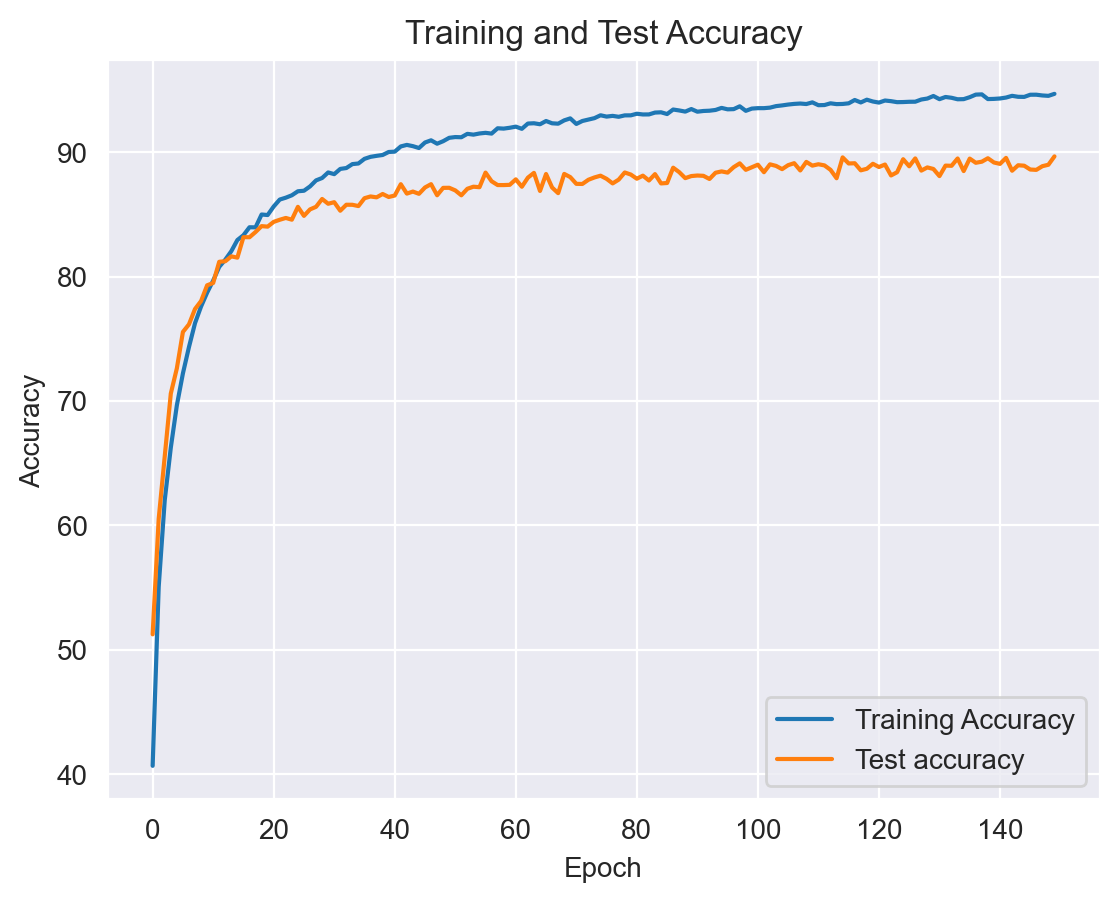

In [106]:
# Plotting average training and test accuracy over epochs
sns.lineplot(x = range(num_epochs), y = train_acc_epoch_avg, label = 'Training Accuracy')
sns.lineplot(x = range(num_epochs), y = test_acc_epoch_avg, label='Test accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

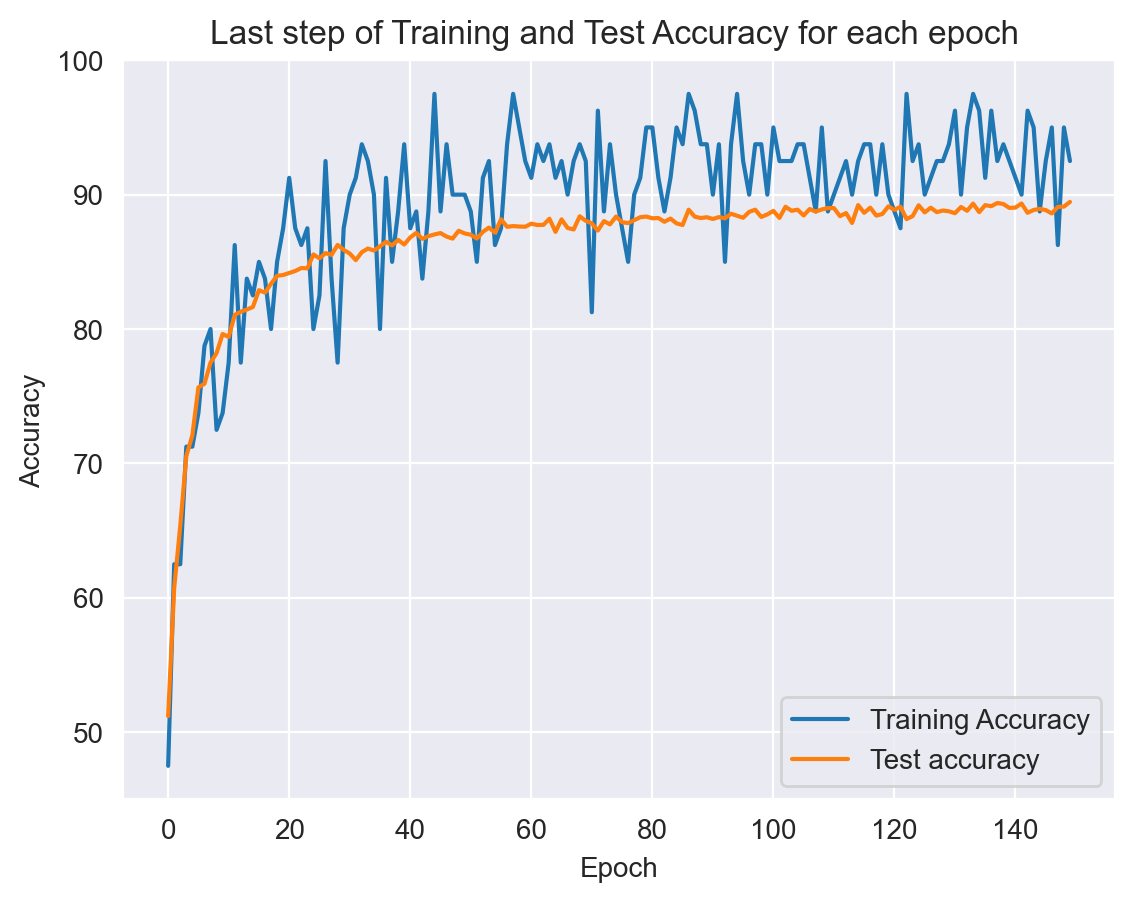

In [107]:
# Plotting the last step of training and test accuracy for each epoch
sns.lineplot(x = range(num_epochs), y = train_acc, label = 'Training Accuracy')
sns.lineplot(x = range(num_epochs), y = test_acc, label='Test accuracy')
plt.legend()
plt.title('Last step of Training and Test Accuracy for each epoch ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### 6.2 Loss Curve

In the following, loss curves for training and validation are shown.


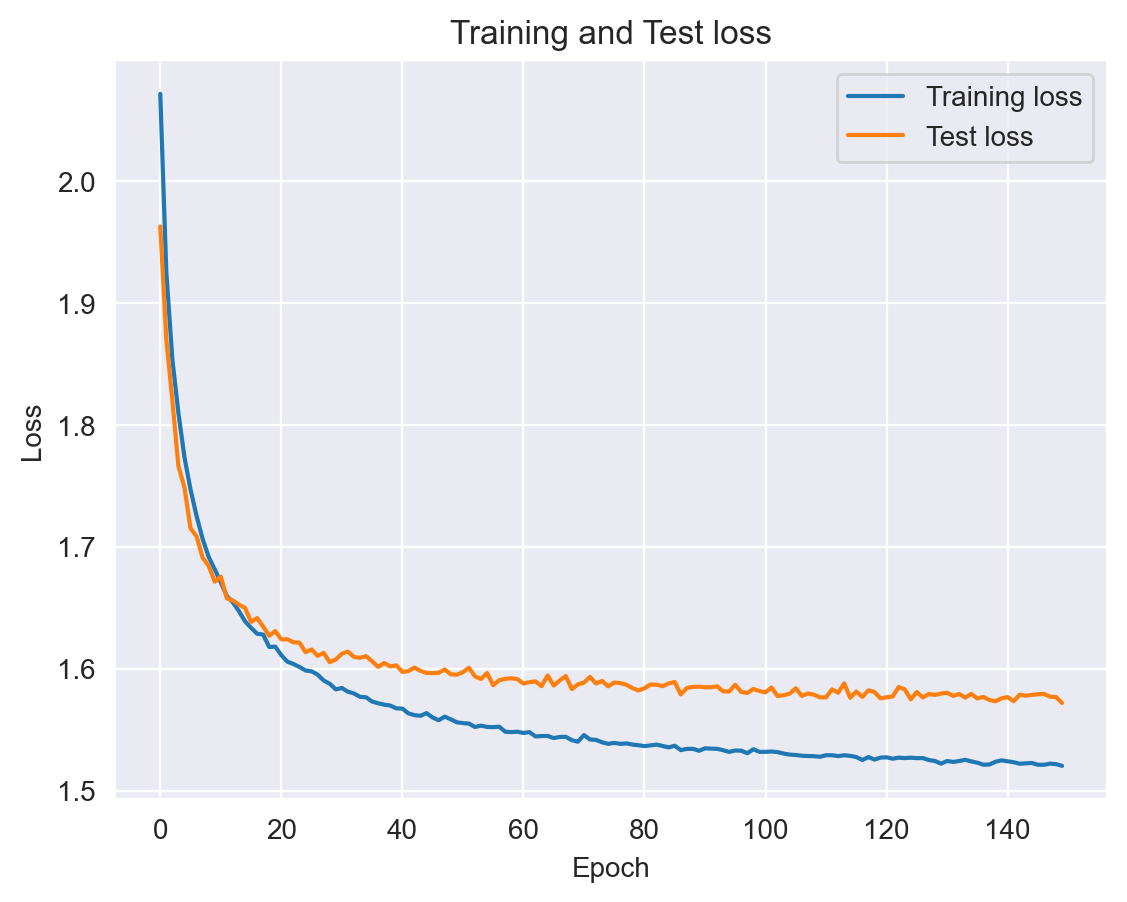

In [111]:
# Plotting the average training and test loss over epochs
sns.lineplot(x = range(num_epochs), y = train_loss_epoch_avg, label = 'Training loss')
sns.lineplot(x = range(num_epochs), y = test_loss_epoch_avg, label='Test loss')
plt.legend()
plt.title('Training and Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

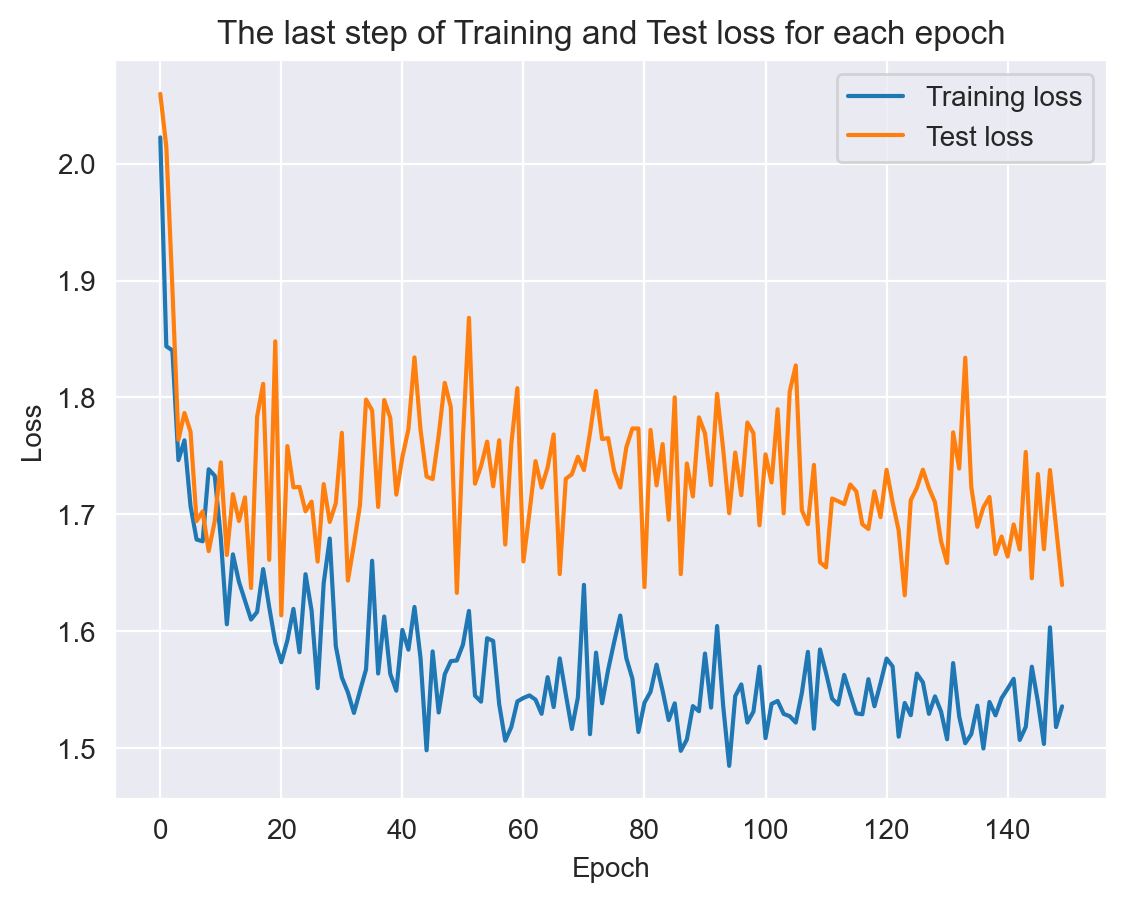

In [112]:
# Plotting the last step of training and test loss for each epoch
sns.lineplot(x = range(len(train_loss)), y = train_loss, label = 'Training loss')
sns.lineplot(x = range(len(test_loss)), y = test_loss, label='Test loss')
plt.legend()
plt.title('The last step of Training and Test loss for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### 6.3 Testing

In the following, we will visualize test accuracy for each classes using heatmap.

reference: "How to create a confusion matrix in PyTorch" https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

Overall accuracy 89.55%


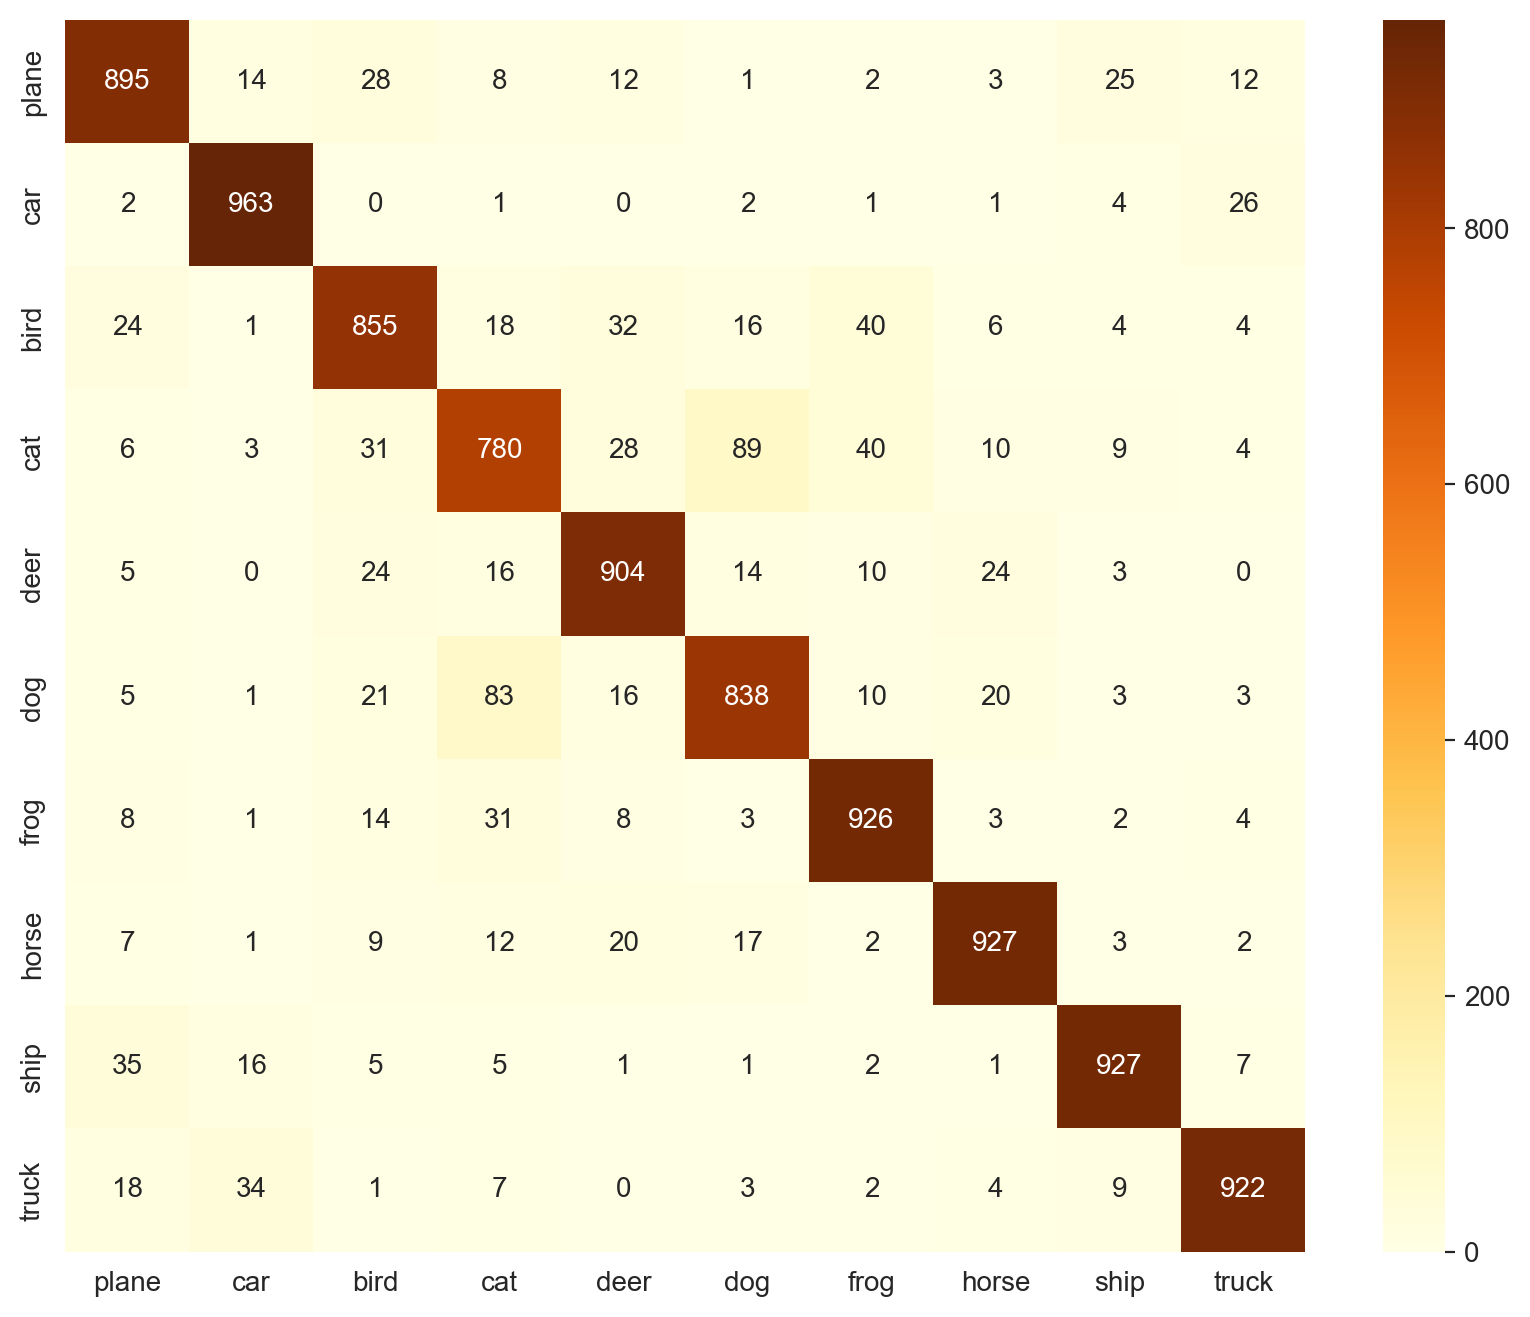

In [78]:
with torch.no_grad():
    #track of the number of correct predictions and total samples
    number_corrects = 0
    number_samples = 0
    
    #Creating dataframe to store counts of predicted vs actual labels
    heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
    
    for i, (test_images_set , test_labels_set) in enumerate(testloader):
        # Save the data to device
        test_labels_set = test_labels_set.to(device)
        test_images_set = test_images_set.to(device)
        
        #Forward Pass
        y_predicted = model(test_images_set)
        y_predicted = y_predicted.to(device)
        
        # Get predicted labels
        labels_predicted = y_predicted.argmax(axis = 1)
        labels_predicted = labels_predicted.to(device)
        
        # Update number of correct predictions and total samples
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)
        
        # Update the counts in the heatmap dataframe
        outputs = model(test_images_set) 
        _, predicted = torch.max(outputs, 1)
        c = (predicted == test_labels_set).squeeze()
        for i in range(test_labels_set.size(0)):
            true_label = test_labels_set[i].item() # Get true label
            predicted_label = predicted[i].item() # Get predicted label
            
            # Update the count for the corresponding cell in the heatmap dataframe
            heatmap.iloc[true_label,predicted_label] += 1 

    # Compute overall accuracy
    print(f'Overall accuracy {(number_corrects / number_samples)*100}%')
    
    # Plot the heatmap
    _, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap='YlOrBr')
    plt.show()


* From the heatmap, it can be observed that the Dog and Cat images are the most frequently misclassified images.